- detect neuron assemblies with spectral graph clustering
- julian moran
- 2022-06-01

In [6]:
import csv
import os
import math
import warnings
import sys
from pathlib import Path
from itertools import chain

import scipy
from scipy import spatial
import sklearn
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [59]:
##########define helper functions##############################

# define cluster colouring helper function
'''
colourClusters()
@desc
    colour graph nodes by cluster membership and return time indices for each cluster
@args
    nodes; ndarray of int
        array of 0:n_nodes; reflects default node-labelling behaviour by networkx
    numClusters; int
        number of clusters
    colours; ndarray of int
        int-labelled array of clusters w/ len(colours) == n_nodes
    colourNames; list of str
        list of colour names to be used for each cluster; suggest tab10 or xckd colours
    timeIndices; ndarray of num
        array of time indices included in the time-nodal graph as per threshold
        order matches colours, nodes, so can be used to pull time-index information for each cluster
        e.g. timeIndices = graph_nodes_counts[0]
'''
def colourClusters(nodes, numClusters, colours, colourNames, timeIndices):

    temp = []

    for i in range(numClusters):
        cluster = nodes[np.where(colours == i, True, False)]
        cluster_timeIndices = timeIndices[np.where(colours == i, True, False)]
        temp.append(cluster_timeIndices)
        nx.draw_networkx_nodes(G, pos, node_color=colourNames[i],  nodelist=cluster, alpha=0.5, node_size=800)

    return temp


# define spectral clustering helper function
def SGC(A, numClusters):
    # compute degree matrix, laplacian
    D = np.diag(A.sum(axis=1))
    L = D - A

    # compute eigenvectors and eigenvalues of laplacian; sort by eigenvalues
    vals, vecs = np.linalg.eig(L)
    vecs = vecs[:, np.argsort(vals)] # np.argsort() returns indices of sorted elements
    vals = vals[np.argsort(vals)]

    # from first n eigenvectors, cluster vector elements into n groups
    #       - each eigenvector binarises the elements into +ve and -ve based on which component they should be grouped into
    #       - KMeans is clustering the vector elements
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(vecs[:, 1:int(numClusters)]) # @juli: originally typed as 1:4 when 4 clusters; what does this line do? 
    colours = kmeans.labels_

    print("Clusters:", colours)
    return colours

In [60]:
##########designate output dir##############################

output_dir = './' + 'SGC_output'
if os.path.isdir(output_dir) == False:
    os.mkdir(output_dir)

In [ ]:
##########read in and trim the data##############################

# set numpy print options so as to display full arrays
np.set_printoptions(threshold=sys.maxsize)


# read in the data
path = 'C://Users//julia//OneDrive//documents//MSc_UToronto_thesis//project_PNCI_pipeline//data//meiZ_2019-10-31_unc-13(s69);unc-2(hp647)hpIs675animal_6run_1//_analysis//2022-01-21_plots_se=V3_& IEsManRemd'
fileName = 'debleached_traces.npy'
filePath_data = Path(path + '//' + fileName)

traces = np.load(filePath_data) #traces is an array with shape (n_channels, n_neurons, n_volumes), with traces[1] being GCaMP channel


# read in neuron names in order-preserved format
fileName = 'neuron_names.txt'
filePath_neurNames = Path(path + '//' + fileName)

trace_names = list()
f = open(filePath_neurNames, 'r')

for line in f:
    trace_names.append(line.strip())


# find out how many traces do not contain all-zeros for initializing a new trimmed array
count_nonZeros = 0

for i in range(1, len(traces[1,])):

    if np.nonzero(traces[1, i])[0].size != 0:
        count_nonZeros += 1

message = 'after trimming out traces containing only nan, ' + str(count_nonZeros) + ' traces remain'
print(message)


# trim all those traces that contain only zeros
traces_trimmed = np.zeros((count_nonZeros, np.shape(traces)[2]), dtype='float64')
trace_names_trimmed = list()
count_temp = 0

for i in range(1, len(traces[1,])):
    
    if np.nonzero(traces[1, i])[0].size != 0:
        traces_trimmed[count_temp, :] = traces[1, i]        
        trace_names_trimmed.append(trace_names[i])
        count_temp += 1

# print(trace_names_trimmed)

In [ ]:
##########remove null rise traces##############################

nullRise_names = [
    'I1R',
    'I1L',
    'NSML',
    'NSMR',
    'Na16',
    'Na20',
    'Na21',
    'Na23',
    'Na26',
    'Na46',
    'Na55',
    'Na57',
    'Na58',
    'Na60',
    'Na61',
    'Na63',
    'Na67',
    'Na73',
    'Na77',
    'Na86',
    'Na89',
    'Na90',
    'Na96',
    'Na98',
    'Na104',
    'Na105',
    'Na109',
    'Na111',
    'Na117',
    'Na119',
    'Na134',
    'Na135',
    'Na137',
    'Na138',
    'Na141'
]

nullRise_indices = []

for i in range(len(trace_names_trimmed)):
    if trace_names_trimmed[i] in nullRise_names:
        nullRise_indices.append(i)

traces_trimmed = np.delete(traces_trimmed, nullRise_indices, axis=0)
trace_names_trimmed = np.delete(trace_names_trimmed, nullRise_indices)

message = 'after trimming out null-rise-patterned traces, ' + str(np.shape(traces_trimmed)[0]) + ' traces remain'
print(message)
print(trace_names_trimmed)


# # make backups to ensure sorting in next cell is robust to reiteration
# trace_names_trimmed_backup = trace_names_trimmed
# traces_trimmed_backup = traces_trimmed

In [ ]:
##########prefix neuron names with xxx.yyy.zzz coordinates##############################

# read in neuron_coords.tsv and neuron_names.tsv
#       - both created by ./interactiveProcessing_byGanglionPrint_nameByCoord.ipynb
#       - both stored in ./
#       - .tsv's are index-matched
with open('neuron_names.tsv') as file:
    tsv_file = csv.reader(file, delimiter='\t')
    for line in tsv_file:
        l_n = line

with open('neuron_coords.tsv') as file:
    tsv_file = csv.reader(file, delimiter='\t')
    for line in tsv_file:
        l_c = line


# edit trace_names_trimmed to include both neuron names and neuron coords
temp = []
for i in range(len(trace_names_trimmed_backup)):
    j = l_n.index(trace_names_trimmed_backup[i])
    c = l_c[j]
    n = l_n[j]

    c_n = c + '_' + n
    temp.append(c_n)

trace_names_trimmed = temp


# sort both trace_names_trimmed and traces_trimmed by coordinates
trace_names_trimmed = sorted(trace_names_trimmed)
traces_trimmed = [z for _,z in sorted(zip(temp, traces_trimmed_backup))] # @juli: sorting kills on multiple iterations of this cell; need variable buffer

# convert lists back to nd.arrays
trace_names_trimmed = np.array(trace_names_trimmed)
traces_trimmed = np.array(traces_trimmed)

# # output message
# message = 'traces and trace names now prefixed and sorted by xxx.yyy.zzz Annotator coordinates, as in:'
# print(message, '\n', trace_names_trimmed)

In [ ]:
##########binarise the data##############################

# here we want to perform the following preprocessing steps
#
#   1. do NOT convert GCaMP intensity to deltaF / F
#       - formula: dF/F =   (F(t) - F0) / F0
#       - in  turn reqs knowing F0; since we are observing the neurons' spontaneous activity, we don't have that information
#       - we can't assume high GCaMP activity throughout recording is merely the result of high GCaMP expression
#       - we can't assume it bc it's possible a neuron is giving a strong tonal activation throughout recording
#
#   2. binarise the signal as active or inactive as per some arbitrary threshold
#       - if use global threshold, this will bias selection toward later time points; RFP noise subtraction model causes artificial null rise
#       - see previous code cell


#convert all nan values to zeros
traces_trimmed = np.nan_to_num(traces_trimmed, nan=0.0)


# calculate threshold on a per-trace basis
thresh_arr = np.zeros(np.shape(traces_trimmed)[0], dtype='float64')

for i in range(0, np.shape(traces_trimmed)[0]):
    mean = np.mean(traces_trimmed[i])
    stdv = np.std(traces_trimmed[i])
    thresh = mean + stdv
    thresh_arr[i] = thresh


# binarise each trace as per its own tailored threshold
upper = 1
lower = 0
traces_binar = np.zeros(np.shape(traces_trimmed), dtype='float64')

for i in range(0, len(thresh_arr)):
    traces_binar[i] = np.where(traces_trimmed[i]>thresh_arr[i], upper, lower)

# print(traces_binar)

In [65]:
##########plot the binarised data##############################

# set /clusters output dir within /SGC_output
output_dir_binar = output_dir + '//' + 'binarPlots'
if os.path.isdir(output_dir_binar) == False:
    os.mkdir(output_dir_binar)


# build plots
for i in range(len(trace_names_trimmed)):

    #set features for plot
    plt.style.use('default')
    plt.style.use('seaborn-muted')
    neuronStr = str(trace_names_trimmed[i]).replace('/', 'or')
    nrows = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=1)
    fig.subplots_adjust(top=0.8)
    fig.set_figheight(25)
    fig.set_figwidth(30)

    # build subplottable data structure
    temp = np.zeros((nrows, np.shape(traces_trimmed)[1]))
    temp[0] = traces_trimmed[i]
    temp[1] = traces_binar[i]

    # build subplots
    for j in range(nrows):
        x = np.arange(0, np.shape(traces_trimmed)[1])
        y = temp[j]
        axs[j].plot(x, y, color='green')
        
        if j == 0:
            subtitle = 'before binarisation'
        elif j == 1:
            subtite = 'after binarisation'

        axs[j].title.set_text(subtitle)
        axs[j].set(xlabel = 'frame', ylabel = 'GCaMP')
    
    fig.suptitle = neuronStr

    # write plot to disc as .svg
    output_name = neuronStr + '_binarPlot' + '.svg'
    output_path = Path(output_dir_binar + '//' + output_name)
    plt.savefig(output_path, format='svg', dpi=480, bbox_inches='tight')

    plt.close()

threshold for active neurons per time is point set to 23.17859993159371


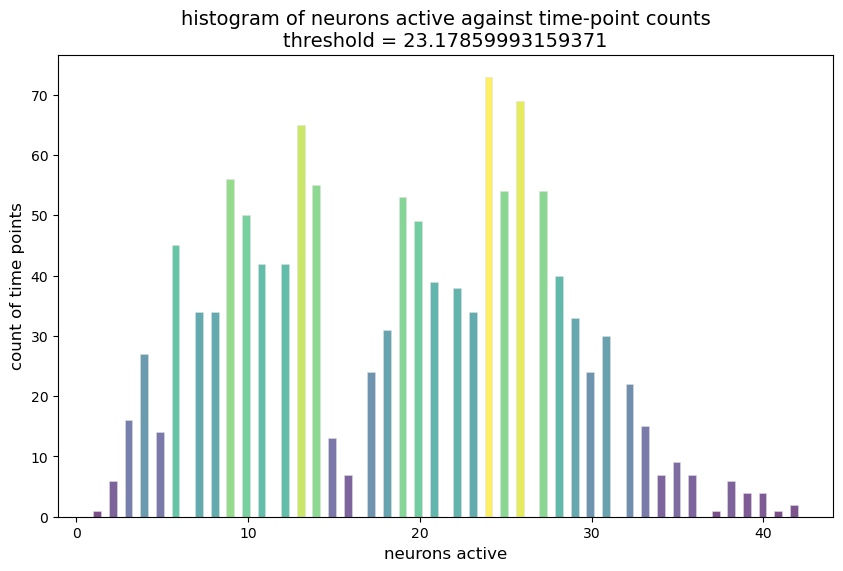

In [66]:
##########define threshold for "high-activity" time points##############################

# for each time point, count how many neurons are active
timePoint_count = np.zeros(np.shape(traces_binar)[1])

for i in range(0, np.shape(traces_binar)[1]):
    count = 0
    
    for j in range(0, np.shape(traces_binar)[0]):
        if traces_binar[j, i] == 1:
            count = count + 1
    
    timePoint_count[i] = count


# define threshold for counts holistically (this could be too stringent and incur selection bias from the end of recording)
mean = np.mean(timePoint_count)
stdv = np.std(timePoint_count)
thresh = mean + 0.5 * stdv

print('threshold for active neurons per time is point set to ' + str(thresh))


# build histogram of time-point counts
fig = plt.figure(figsize=(10,6))
plt.style.use('default')
plt.style.use('seaborn-muted')
n, bins, patches = plt.hist(timePoint_count, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

title = 'histogram of neurons active against time-point counts'
subtitle = '\nthreshold = ' + str(thresh)
title = title + subtitle

plt.title(title, fontsize=14)
plt.xlabel('neurons active', fontsize=12)
plt.ylabel('count of time points', fontsize=12)

output_name = 'SGC_hist_nodes.svg'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='svg', dpi=1200)

output_name = 'SGC_hist_nodes.png'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='png', dpi=1200)

plt.show()

In [ ]:
##########find graph nodes##############################

range_temp = np.arange(np.shape(traces_binar)[1])
temp_frameIndex = list()
temp_neuronCount = list()

for i in range(0, len(timePoint_count)):
    if timePoint_count[i] > thresh:
        temp_neuronCount.append(timePoint_count[i])
        temp_frameIndex.append(range_temp[i])

graph_nodes_counts = np.zeros((2, len(temp_neuronCount)), dtype='float64')
for i in range(0, len(temp_neuronCount)):
    graph_nodes_counts[0, i] = temp_frameIndex[i]
    graph_nodes_counts[1, i] = temp_neuronCount[i]


# build the time graph
#
#       - remember, order-preserved, member-complete information on the neuron names is stored in traces_names_trimmed
#
#       - remember, order-preserved, member-complete information on the time points to pull is stored in graph_nodes_count[0]
#
#       - for each time point, assemble a k-long array, ...
#               + where we have k-number of neurons
#               + where each element is the binarised activity level of a neuron
#               + e.g. 214 time points * 110 neurons

graph_nodes = np.zeros((np.shape(graph_nodes_counts)[1], np.shape(traces_binar)[0]), dtype='float64')

for i in range(0, np.shape(graph_nodes)[0]): # iterates through time points
    
    for j in range(0, np.shape (graph_nodes)[1]): # iterates through neurons
       graph_nodes[i, j] = traces_binar[j, int(graph_nodes_counts[0, i])]

# print('graph-node time indices and counts:')
# print(graph_nodes_counts)
# print('graph nodes:')
# print(graph_nodes)

threshold for displayable edge weight is 0.7772496708433125


<function matplotlib.pyplot.show(close=None, block=None)>

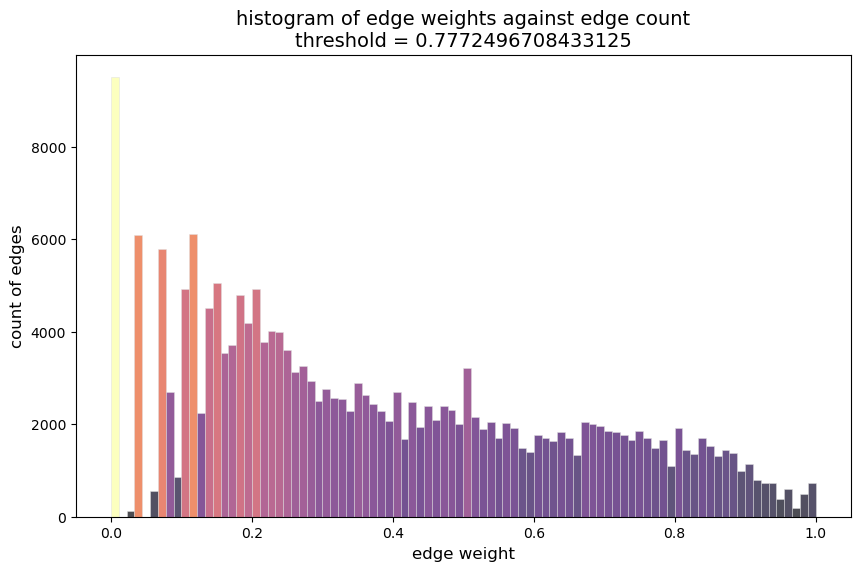

In [68]:
##########find graph weights (undirected)##############################

# calculate cosine distance of non-binarised activity at nodes identified in previous cell
n = np.shape(graph_nodes)[0]
A = np.zeros((n, n), dtype='float64')

for i in range(0, n):
    for j in range(0, n):
        d = 1 - spatial.distance.cosine(graph_nodes[i], graph_nodes[j])
        A[i, j] = d


# set threshold weight as 2 standard deviations above mean
A_temp = A.flatten()

mean = np.mean(A_temp)
stdv = np.std(A_temp)
thresh = mean + (1.5 * stdv)

print('threshold for displayable edge weight is ' + str(thresh))


# build histogram of edge values (bin size = 0.1)
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

fig = plt.figure(figsize=(10,6))
plt.style.use('seaborn-muted')
n, bins, patches = plt.hist(A_temp, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.inferno(n[i]/max(n)))

title = 'histogram of edge weights against edge count'
subtitle = '\nthreshold = ' + str(thresh)
title = title + subtitle

plt.title(title, fontSize=14)
plt.xlabel('edge weight', fontSize=12)
plt.ylabel('count of edges', fontSize=12)

output_name = 'SGC_hist_edges.svg'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='svg', dpi=1200)

output_name = 'SGC_hist_edges.png'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='png', dpi=1200)

plt.show

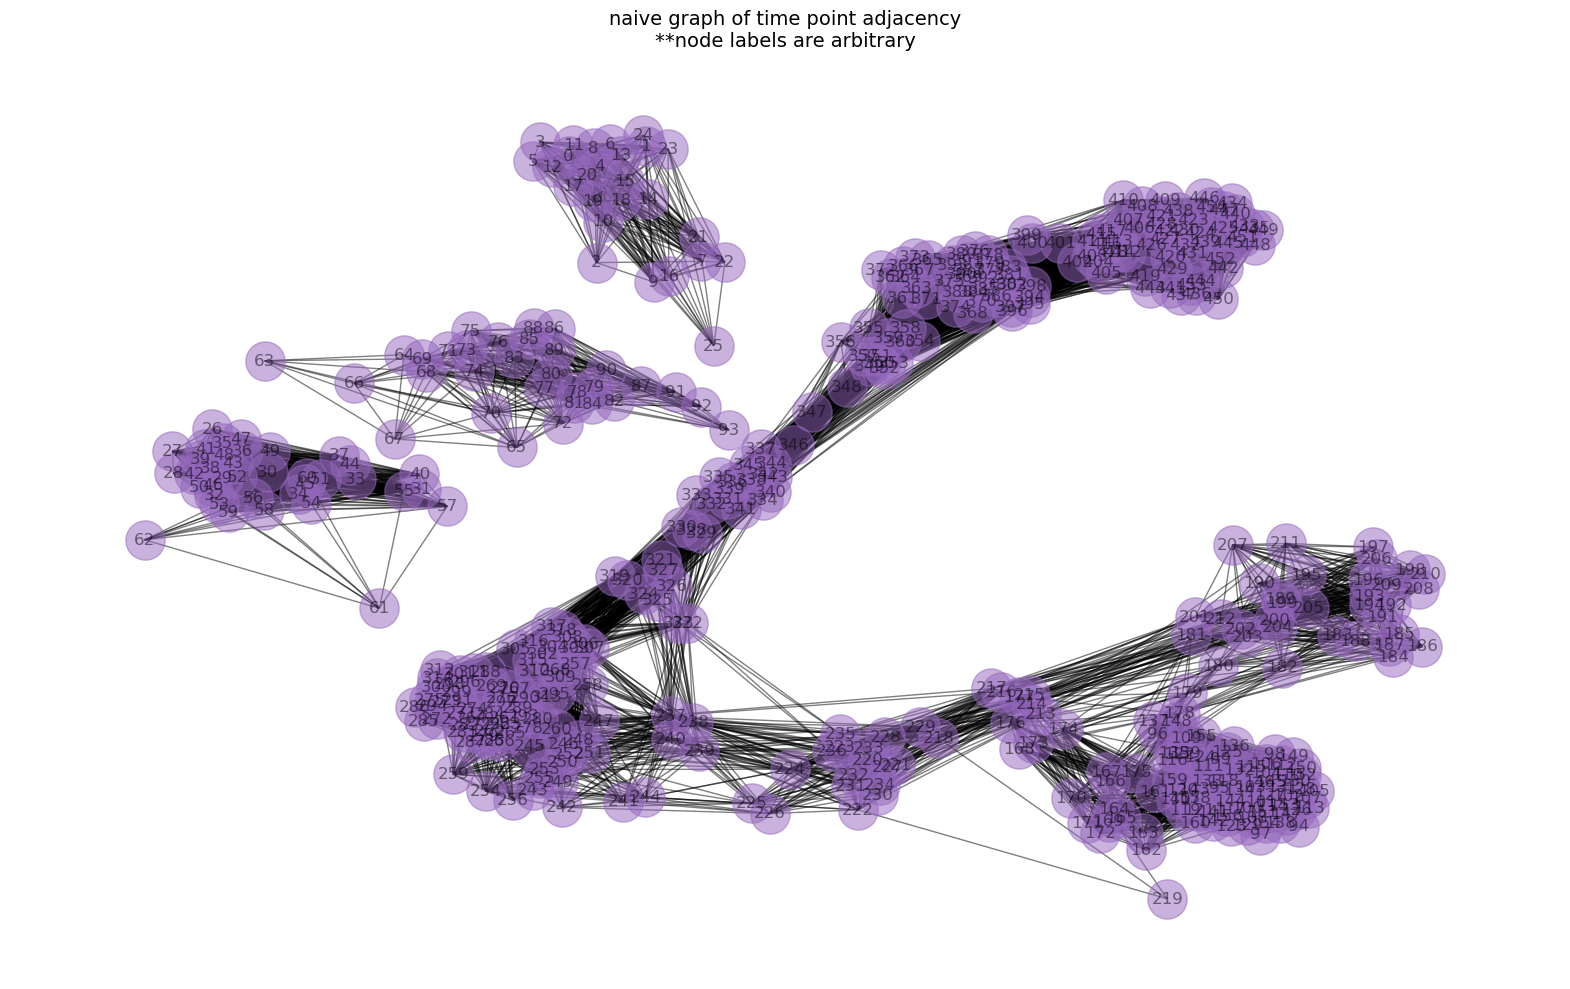

In [69]:
##########plot the naive undirected graph##############################

# "naive graph"
#       - my naive approach to constructing a graph
#       - preserves all connections and weights; i.e.ultra-densely connected
#       - no thresholding of weights in inferring community structure
#       - no calculating of k-nearest neighbor
#       - finding: this graph performs poorly relative to k-nearest neighbor graph
#
# here, we are ommitting the weights from the labelling
#       - for visualization purposes
#
# here, we are presenting a version of the graph with no community structure inference
#       - however, by binarising the weights (A_binar) as per a high threshold...
#       - we are isolating only strong correlations; this could be predictive of community structure
#
# note
#       - node labels are indices within the time array (e.g. indices 0:214)
#       - they must be linked back to the time array to get the actual time nodes when inferring community structure


# binarize A using threshold
A_binar = np.where(A > thresh, 1, 0)
A_binar = A_binar.astype('int8')

# build graph
title = 'naive graph of time point adjacency\n**node labels are arbitrary'

plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_binar)
G.remove_edges_from(nx.selfloop_edges(G))

pos = nx.spring_layout(G, k=0.2, iterations=30) # k is internodal distance; iterations is number of times simulated annealing is run
nx.draw(G, pos, node_color='tab:purple', alpha=0.5, node_size=800, with_labels=True)

plt.show()

Clusters: [ 0 15 15  6  7 15 15 15 15 15 15 15 15 15 15 12  5 10 13 11  9  8  1  3
  4  2 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 16 14  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  

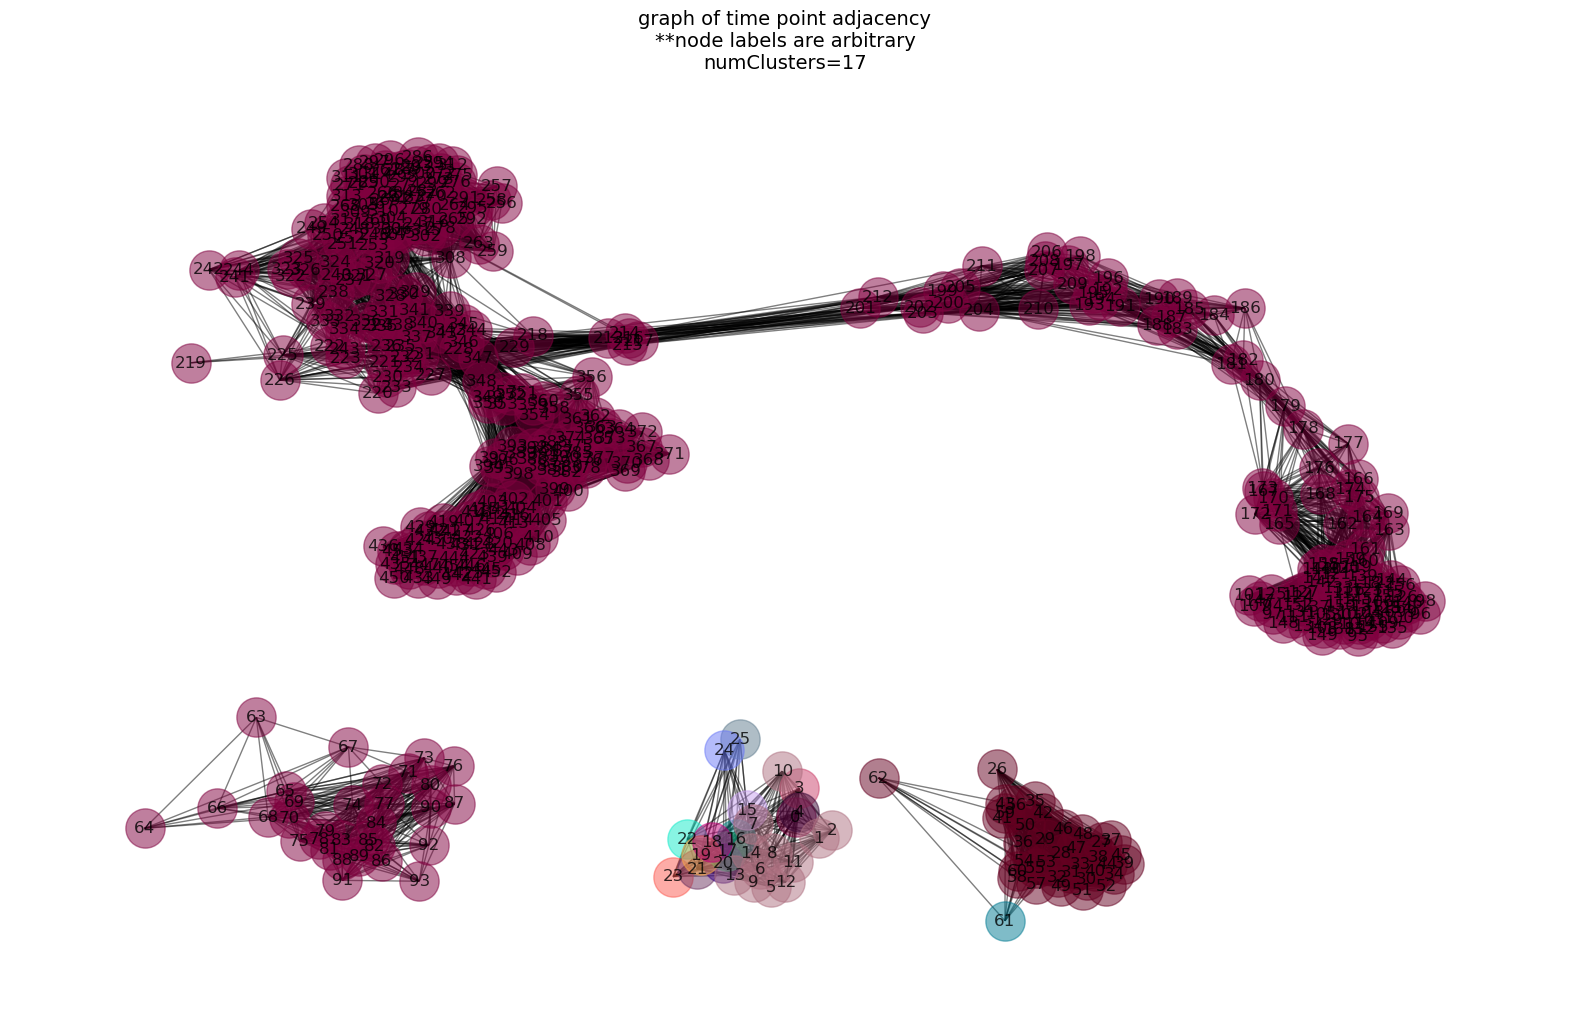

In [70]:
##########try SGC community inference approach##############################

# SGC (spectral graph clustering)
#       - as described in https://towardsdatascience.com/spectral-clustering-aba2640c0d5b


# define number of clusters and graph title
numClusters = 17
title = 'graph of time point adjacency\n**node labels are arbitrary\n' + 'numClusters=' + str(numClusters)

#perform SGC
colours = SGC(A=A, numClusters=numClusters)

# build clustered graph
plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_binar)
G.remove_edges_from(nx.selfloop_edges(G))

pos = nx.spring_layout(G, k=0.2, iterations=40)

colourNames = [
    'xkcd:wine',
    'xkcd:aqua',
    'xkcd:blue grey',
    'xkcd:coral',
    'xkcd:cornflower',
    'xkcd:dark cyan',
    'xkcd:dark pink',
    'xkcd:eggplant',
    'xkcd:grape',
    'xkcd:indigo',
    'xkcd:jade',
    'xkcd:light orange',
    'xkcd:lavender',
    'xkcd:magenta',
    'xkcd:maroon',
    'xkcd:mauve',
    'xkcd:ocean',
    'xkcd:orange yellow',
    'xkcd:pale teal',
    'xkcd:peach',
    'xkcd:pinkish red',
    'xkcd:rose',
    'xkcd:red purple',
    'xkcd:reddish',
    'xkcd:salmon',
    'xkcd:seafoam green',
    'xkcd:tan',
    'xkcd:turquoise',
    ]

nodes = np.arange(np.shape(A_binar)[0])

clusters = colourClusters(
    nodes=nodes,
    numClusters=numClusters,
    colours=colours,
    colourNames=colourNames,
    timeIndices=graph_nodes_counts[0]
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, alpha=0.8)

plt.grid(False)
plt.axis("off")

plt.show()

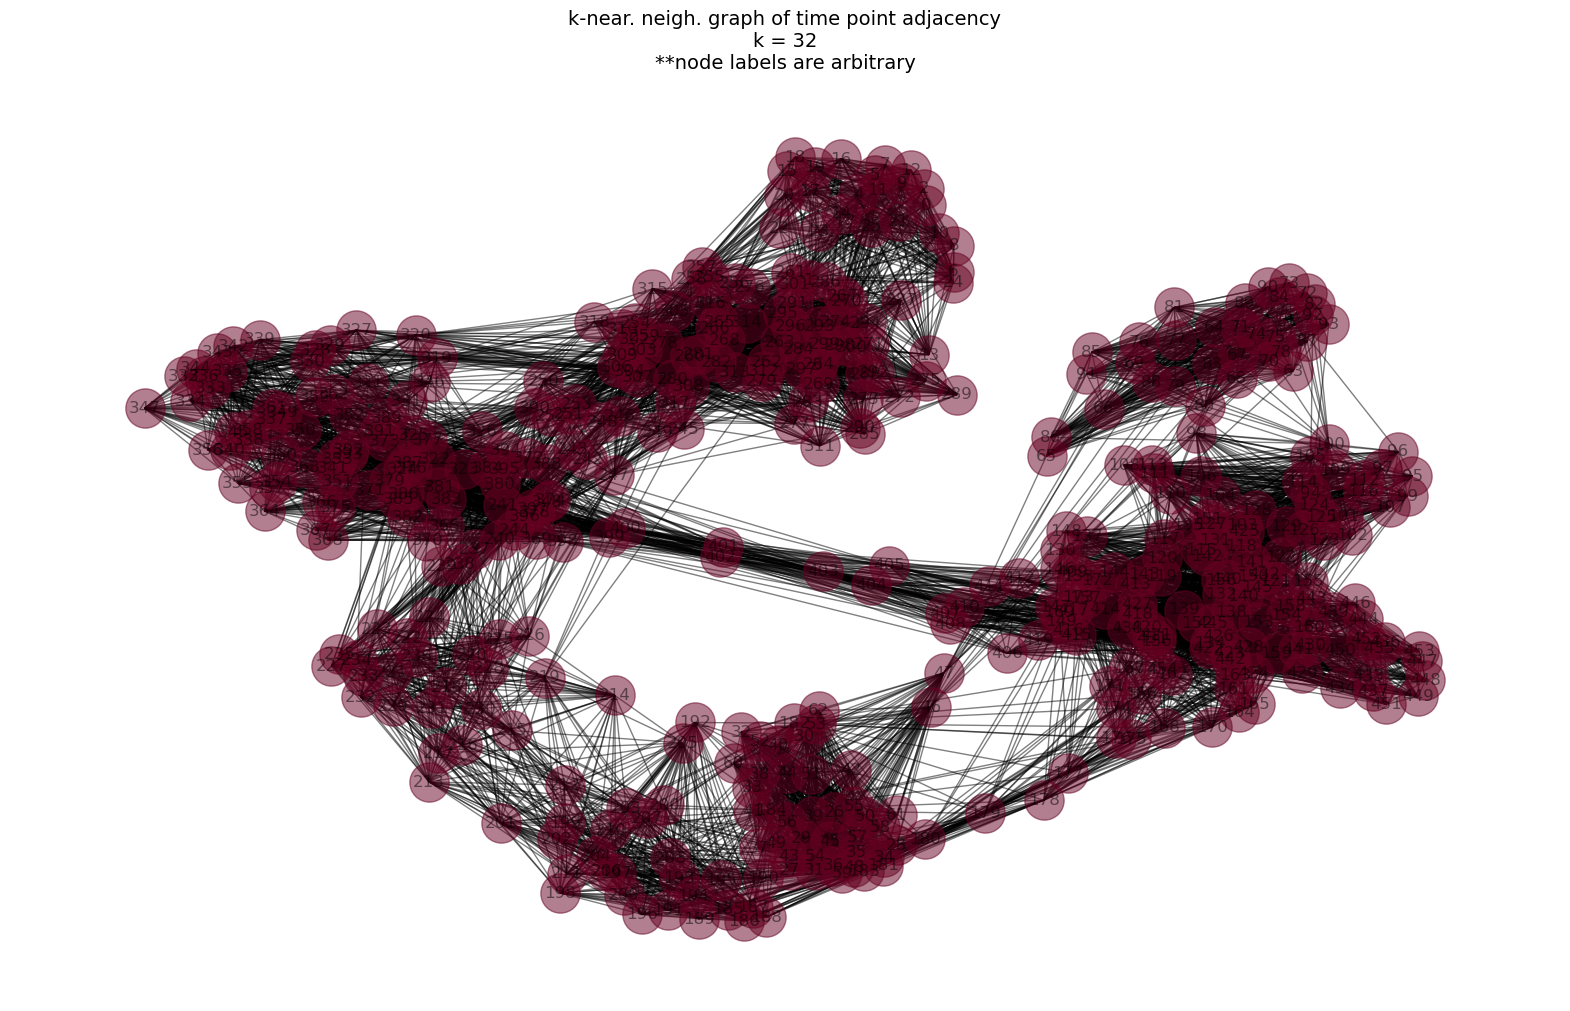

In [71]:
##########build k-nearest-neighbor graph##############################

# as prescribed by molter2018:
#       
#       - for finding threshold edge weight
#
#           use unweighted k-nearest neighbor graph
#               k is edge-threshold for whether nodes are connected
#               k is an integer; for each node, the k-nearest neighbors receive an edge
#               start with k = ln(n) and increment by k+=1 until all nodes are connected
# 
#           can build k-nearest-neighbor graph using sklearn.neighbors kneighbors_graph function
#               https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html
#               takes raw vectors as input rather than adj matrix
#               set n_neighbors=ln(len(graph_nodes_count[0]))
#               set mode:connectivity return adjacency matrix as unweighted
#               set metric="cosine"; uses cosine distance
#               find A=1-A.data to find cosine similarity
#               G = nx.from_scipy_sparse_matrix(A, )

# find k for k-nearest neighbor graph
k = int(math.log(len(graph_nodes_counts[0]))) + 26


# build k-nearest-neighbor scipy matrix object (unweighted, undirected)
A_kn = kneighbors_graph(graph_nodes, k, metric="cosine", mode="connectivity", include_self=True)
A_kn = A_kn.toarray() # nearest neighbors match what's seen in manually computed adjacency matrix
# print(str(np.shape(A_kn)) + '\n', A_kn)
A_kn = A_kn.astype('int8')


# build unweighted k-nearest-neighbor graph
title = 'k-near. neigh. graph of time point adjacency\nk = ' + str(k) + '\n**node labels are arbitrary'


plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)
G = nx.from_numpy_matrix(A_kn)
# G = nx.from_scipy_sparse_matrix(A_kn)

G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G, k=0.2, iterations=20)
nx.draw(G, pos, node_color='xkcd:maroon', alpha=0.5, node_size=800, with_labels=True)

output_name = 'SGC_KNNgraph.svg'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='svg', dpi=1200)

output_name = 'SGC_KNNgraph.png'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='png', dpi=1200)

plt.show()


# find number of clusters
###insert code here; there is supposed to be a non-arbitary approach to this when spectral gap is non-obvious

Clusters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 1 6 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1
 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 1 1 1
 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]


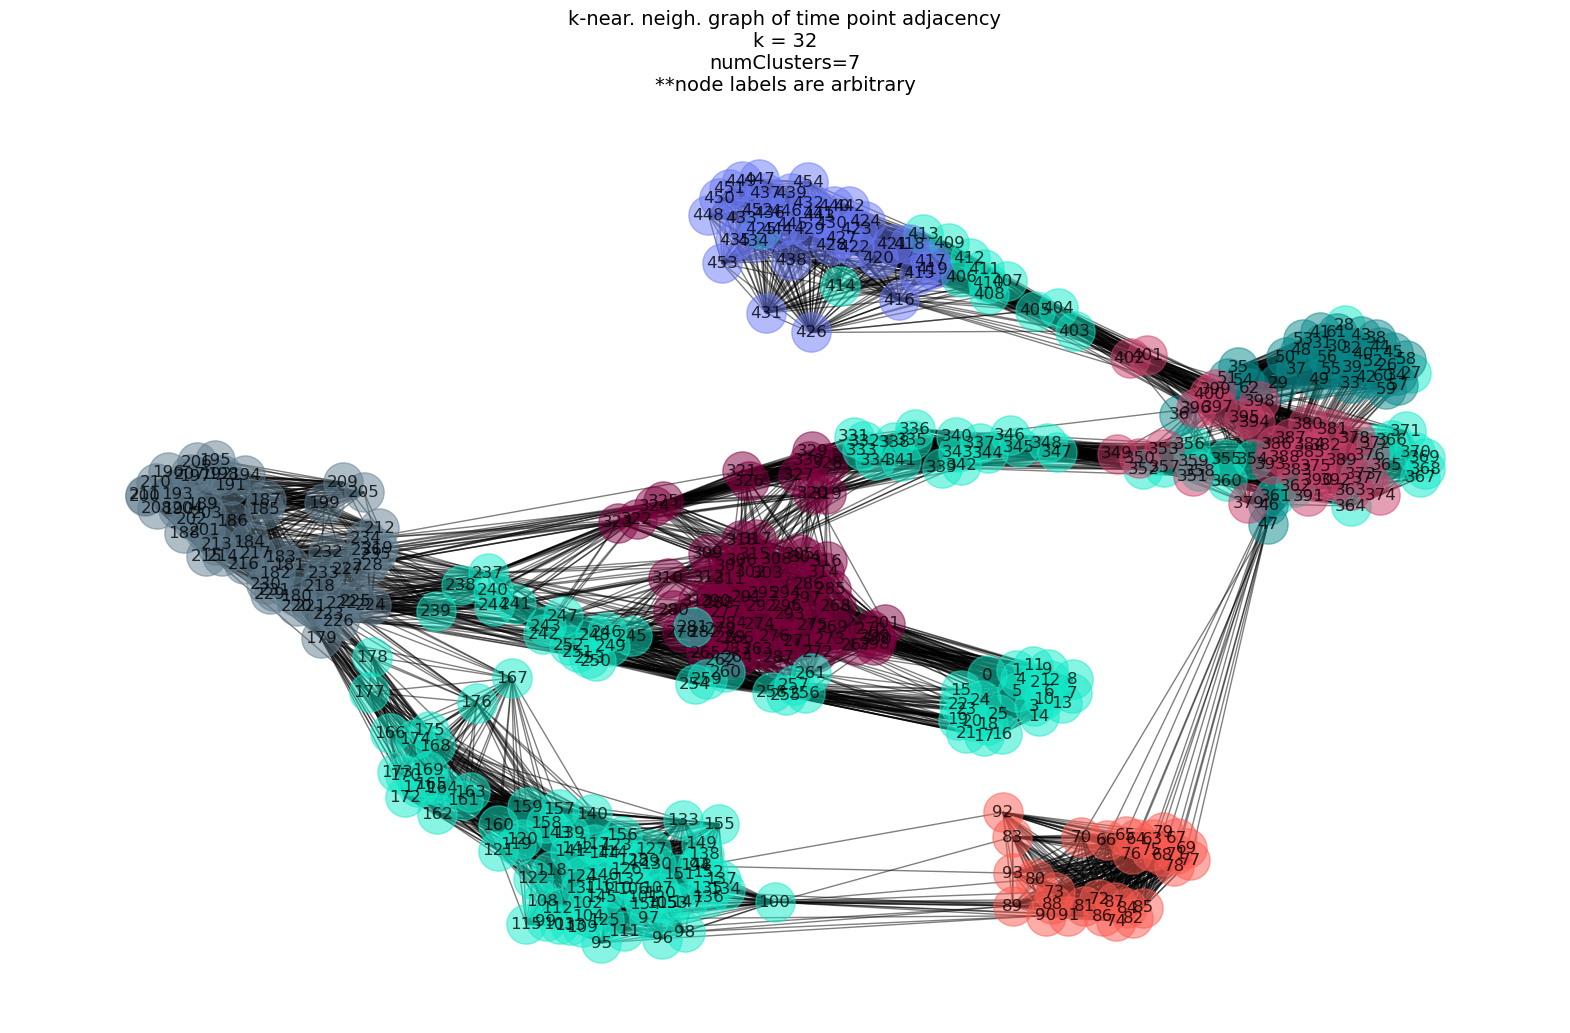

In [72]:
##########perform SGC on KNN graph##############################

# perform SGC
D_kn = np.diag(A_kn.sum(axis=1))
L_kn = D_kn - A_kn

vals_kn, vecs_kn = np.linalg.eigh(L_kn)
vecs_kn = vecs_kn[:, np.argsort(vals_kn)]
vals_kn = vals_kn[np.argsort(vals_kn)]

n_clusters = 7
# @juli: techniques exist to fit a degree-corrected stochastic block to the graph
#       this gives numClusters in a non-arbitrary fashion
#       see molter2018 pg. 14

kmeans_kn = KMeans(n_clusters=n_clusters)
kmeans_kn.fit(vecs_kn[:, 1:n_clusters])
colours_kn = kmeans_kn.labels_

print("Clusters:", colours_kn)

title = 'k-near. neigh. graph of time point adjacency\nk = ' + str(k) + '\nnumClusters=' + str(n_clusters) + '\n**node labels are arbitrary'

plt.figure(3, figsize=(20,12))
plt.title(title, fontSize=14)

G = nx.from_numpy_matrix(A_kn)
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.spring_layout(G, k=0.1, iterations=20)

nodes_kn = np.arange(np.shape(A_kn)[0])

clusters_kn = colourClusters(
    nodes=nodes_kn,
    numClusters=n_clusters,
    colours=colours_kn,
    colourNames=colourNames,
    timeIndices=graph_nodes_counts[0]
    )

nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, alpha=0.8)

plt.grid(False)
plt.axis("off")

output_name = 'SGC_KNNgraph_clustered.svg'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='svg', dpi=1200)

output_name = 'SGC_KNNgraph_clustered.png'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='png', dpi=1200)

plt.show()

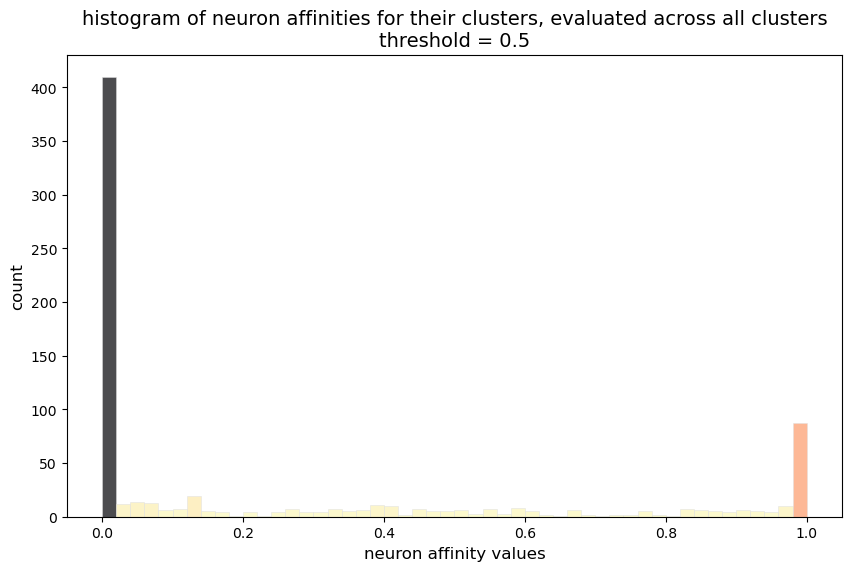

In [73]:
##########find neuroactivity assemblies##############################

# find mean activity for each neuron within each time-node cluster
#       - using binarised activity as input
#       - will give value between 0 and 1 ("affinity")
#
# designate affinity threshold e.g. =0.8
#       - neurons with affinity >=threshold get included in neuroactivity assembly
#
# skipping from molter2018: trimming out some time-node clusters as noise
#
# skipping from milter2018: merging some time-node clusters together if the high-affinity neurons match close enough
#       - notation for this step in molter2019 is unfollowable
#       - that said, i can probably develop a naive approach of my own if i decide i want to do this


# binarise neuronAffinities; set arbitary threshold for affinity
upper = 1
lower = 0
thresh_aff = 0.5


# build time-node clusters from frame-indices specified in clusters_kn
clusteredData_kn = [] # want list of n_clusters nd.arrays, each in turn containing time-node arrays w/ n_neurons elements

for i in range(len(clusters_kn)): # iterates through time-node clusters
    cluster_temp = np.zeros((np.shape(clusters_kn[i])[0], np.shape(graph_nodes)[1]))
    
    for j in range(np.shape(clusters_kn[i])[0]): # iterates through each time node in a cluster
        temp = clusters_kn[i][j]
        l = np.where(graph_nodes_counts[0]==temp)
        l = l[0][0] # pulls time node's index

        cluster_temp[j] = graph_nodes[l] # adds time node to cluster_temp
    
    clusteredData_kn.append(cluster_temp)


# find average of each neuron's element over each time node in each cluster
neuronAffinities = np.zeros((len(clusteredData_kn), np.shape(graph_nodes)[1]))

for i in range(len(clusteredData_kn)): # iterates through each cluster
    
    for j in range(np.shape(graph_nodes)[1]): # iterates through each neuron
        temp = np.zeros(np.shape(clusteredData_kn[i])[0])

        for l in range(np.shape(clusteredData_kn[i])[0]): # iterates through each time node in the cluster
            temp[l] = clusteredData_kn[i][l, j]

        affinity = np.mean(temp)
        neuronAffinities[i, j] = affinity # pulls neuron's affinity for the time-node cluster


# set affinity threshold as per vibes
affins_temp = neuronAffinities.flatten()


# plot histogram of neuron affinities
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

fig = plt.figure(figsize=(10,6))
plt.style.use('default')
plt.style.use('seaborn-muted')

n, bins, patches = plt.hist(affins_temp, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
n = n.astype('int')

for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.magma_r(n[i]/max(n)))

title = 'histogram of neuron affinities for their clusters, evaluated across all clusters'
subtitle = '\nthreshold = ' + str(thresh_aff)
title = title + subtitle

plt.title(title, fontSize=14)
plt.xlabel('neuron affinity values', fontSize=12)
plt.ylabel('count', fontSize=12)

output_name = 'SGC_hist_affinities.svg'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='svg', dpi=1200)

output_name = 'SGC_hist_affinities.png'
output_path = Path(output_dir + '//' + output_name)
plt.savefig(output_path, format='png', dpi=1200)

plt.show

neuronAffinities_binar = np.zeros(np.shape(neuronAffinities), dtype='int8')

for i in range(np.shape(neuronAffinities)[0]):
    temp = np.where(neuronAffinities[i]>=thresh_aff, upper, lower)
    neuronAffinities_binar[i] = temp

In [74]:
##########reconfigure data structure##############################

# convert neuron_affinities into list of dicts (LD)
#       - where, in each dict, traces_names_trimmed are the keys and neuronAffinities are the values
#       - where there are n_clusters dicts in the list
neuronAffinities_LD = []
for i in range(np.shape(neuronAffinities_binar)[0]): # iterates through clusters
    d = {}
    for G, H in zip(trace_names_trimmed, neuronAffinities_binar[i]): # iterates through neurons
        d[G] = H
    neuronAffinities_LD.append(d)


# remove any elements with value==0 from cluster dicts
neuronAffinities_LD_1s = []
for i in range(len(neuronAffinities_LD)): # iterates through clusters
    d = {G: H for G, H in neuronAffinities_LD[i].items() if H != 0}
    neuronAffinities_LD_1s.append(d)


# store neuron names as list of lists
#       - where outer lists are clusters
#       - where inner lists are neuron names within each cluster
clusters_neurNames = []
for i in range(len(neuronAffinities_LD_1s)):
    l = []
    for G in neuronAffinities_LD_1s[i]:
        l.append(G)
    clusters_neurNames.append(l)


# build list of clusters...
#       - where each cluster is a dict with keys:values like neuron_name:nd.array_of_trace
#       @juli: something going wrong at this stage
clusters_traces = []
for cluster in clusters_neurNames:
    d = {}
    for name in cluster:
        i = np.where(trace_names_trimmed == name) # @juli: problem code
        d[name] = traces_trimmed[i]
    clusters_traces.append(d)


message1 = 'clustered traces stored in var:clusters_traces'
message2 = 'data struture: ' + 'list of clusters, where each cluster is a dict with keys:values like neuron_name:nd.array_of_trace'
message = message1 + '\n\n' + message2
print(message)

# @juli: each value in clusters_traces is an empty array.... need to find out why

clustered traces stored in var:clusters_traces

data struture: list of clusters, where each cluster is a dict with keys:values like neuron_name:nd.array_of_trace


In [75]:
##########plot the clusters##############################

# define subplotting helper function to plot each neuron's GCaMP curve
def subplotTrace(i, neuronName, data, q):

    x = np.arange(0, np.shape(traces_binar)[1], dtype=int)
    y = data[q][neuronName][0]
    axs[i].plot(x, y, color='green')
    axs[i].title.set_text(str(neuronName))
    axs[i].set(xlabel = 'frame', ylabel = 'GCaMP')
    ymin = 0
    ymax = np.max(data[q][neuronName][0])
    axs[i].vlines(clusters_kn[q], ymin, ymax, color='orange', lw=0.7, alpha=0.5) # mark cluster's time nodes

    return None


# set /clusters output dir within /SGC_output
output_dir_clusters = output_dir + '//' + 'clusters'
if os.path.isdir(output_dir_clusters) == False:
    os.mkdir(output_dir_clusters)


# iterate over each cluster to generate plots for that cluster
for q in range(len(clusters_traces)):

    # set features of the whole plot
    plt.style.use('default')
    plt.style.use('seaborn-muted')
    title = 'neuroactivity assembly ' + str(q)
    n_neurons = len(clusters_traces[q])
    fig, axs = plt.subplots(n_neurons) # n_neurons gives number of subplot rows
    fig.subplots_adjust(top=0.98)
    fig.set_figheight(10 * n_neurons + 5)
    fig.set_figwidth(30)

    # generate subplots for each neuron in cluster
    for i in range(n_neurons):
        key = list(clusters_traces[q].keys())[i]
        subplotTrace(i=i, neuronName=key, data=clusters_traces, q=q)

    fig.suptitle(title, fontSize=24, y=0.99)

    # write to disc as .svg
    output_name = 'traces_cluster' + str(q) + '.svg'
    output_path = Path(output_dir_clusters + '//' + output_name)
    plt.savefig(output_path, format='svg', dpi=480, bbox_inches='tight')

    plt.close()

In [10]:
##########debug console##############################
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)


sklearn.__version__

'0.23.2'

In [ ]:
# notes on naive-graph eigenvalues here
#       - only one eigenvalue close to zero; clustering is low-performance
#       - rest show gradual change from 1.3e+03 to 1.8e+02
#       - suggests there is no neat way to cluster this data as it stands; this might make sense, as the graph is heavily densely connected
#       - (bear in mind, the figure displays only a minority of the edges; in fact there are multitudes more that are not displayed in the naive-graph figures)
#       - soln2: use unweighted k-nearest-neioghbor graph instead (done)

# general notes on time-cluster performance
#       - the prevailing variable driving time-node similarity is time proximity
#       - i.e. time nodes that are close in time (e.g. t=1009 and t=1007) get clustered together
#       - i.e. time nodes that are far in time (e.g. t=1009 and t=422) get clustered apart
#       - this may mean that the entire analysis strategy will fail to find meaningful neuroactivity relationships
#       - soln4: rethink how you're binarising the data
#       - soln5: increase num_clusters

'''
concerns

1.      in selecting only those time points that have a certain n neurons active...
                we are biasing selection to frames at the end of recording
                i.e. information at the beginning of the recording will not be incorporated into the graph
 

        soln? debleach the traces better
        - this could flatten the "null rise" traces
        - will have to check how to tailor the debleach curve-fitting window to each trace individiually
        - tried this; i cannot for the life of me get mahdi's denoising approach to do this properly


        soln? manually remove some traces from analysis (TRY FIRST)
        - manually remove traces that exhibit "null rise" pattern
        - i.e. Na135, Na138, etc.


        soln? re-think how you're binarising the data
        - try disabling binarisation; what results do we get then?
        - try implementing "scanning threshold" on each trace; thresh calc'd from -k:k elements around point of interest
'''